In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import supabase

In [2]:
# Reload the datasets using the specified parameters
data = pd.read_csv('data_for_spb_hakaton_entities1-Table 1.csv', skiprows=1, sep=';', encoding='utf-8')
history_table = pd.read_csv('history-Table 1.csv', skiprows=1, sep=';', encoding='utf-8')
sprint_table = pd.read_csv('sprints-Table 1.csv', skiprows=1, sep=';', encoding='utf-8')

In [3]:
status_categories = {
    "К выполнению": ['Создано', 'Готово к разработке', 'Анализ', 'В ожидании', 'Отложен'],
    "В работе": ['В работе', 'Тестирование', 'Разработка', 'Подтверждение', 'Подтверждение исправления', 'СТ', 'Исправление'],
    "Сделано": ['Закрыто', 'Выполнено', 'СТ Завершено', 'Отклонен исполнителем', 'Локализация']
}

In [4]:
history_table['history_change'] = history_table['history_change'].fillna('')
history_table = history_table.dropna(subset=['entity_id']).reset_index(drop = True)
data.loc[:,'rank'] = data['rank'].replace('0|qzzywj:zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzm','0|qzzywj:')
data.drop_duplicates(subset='entity_id')
history_table = history_table.drop(columns=['Столбец1','Unnamed: 7'])
data['create_date'] = pd.to_datetime(data['create_date'])  
data['update_date'] = pd.to_datetime(data['update_date'])
history_table['history_date'] = pd.to_datetime(history_table['history_date'], errors='coerce')

C:\Users\Matvey\AppData\Local\Temp\ipykernel_2420\384267789.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  history_table['history_date'] = pd.to_datetime(history_table['history_date'], errors='coerce')


In [5]:
sprint_table['sprint_start_date'] = pd.to_datetime(sprint_table['sprint_start_date'], errors='coerce')
sprint_table['sprint_end_date'] = pd.to_datetime(sprint_table['sprint_end_date'], errors='coerce')
sprint_table['entity_ids'] = sprint_table['entity_ids'].apply(lambda x: eval(x) if isinstance(x, str) else [])
sprint_data = sprint_table.explode('entity_ids').rename(columns={'entity_ids': 'entity_id'})
sprint_data['entity_id'] = pd.to_numeric(sprint_data['entity_id'], errors='coerce')

In [6]:
data['create_date'] = pd.to_datetime(data['create_date'], errors='coerce')

In [7]:
status_distribution = data['status'].value_counts(normalize=True) * 100

In [8]:
history_table['time_in_status'] = history_table.groupby('entity_id')['history_date'].diff()
history_table = history_table.merge(data, on='entity_id', how='inner')

In [9]:
group = history_table.groupby(['entity_id','status'])['time_in_status'].sum().to_frame()
group = group.reset_index()

In [27]:
def take_info_with_id(i,time_start,time_end):
    entity_id = i
    entity_id = take_sprint_id(entity_id)
    entity_sprint_info = sprint_table[sprint_table['entity_ids'].isin(entity_id)]
    interval_history = history_table[(history_table['history_date'] >= time_start) & (history_table['history_date'] <= time_end)]
    interval_history = interval_history[interval_history['entity_id'].isin(entity_id)]
    interval_history = take_data_interval(interval_history)
    entity_info = group[group['entity_id'].isin(entity_id)]
    return  interval_history

def take_data_interval(interval):
    group1 = interval.groupby(['estimation'])['spent'].sum().reset_index()
    #group1.reset_index().sum() #estimation и spent 
    total_estimation = group1['estimation'].sum()
    total_spent = group1['spent'].sum()
    backlog_df = interval[interval['status'] == 'Отложен'] #Бэклог задачи

    return {'total_estimation': total_estimation,'total_spent':total_spent, 'backlog': len(backlog_df), 'count_normal_task':len(interval)-len(backlog_df)}

def take_sprint_id(i):
    sprints_arr = list(sprint_table['entity_ids'][i])
    return sprints_arr

In [47]:
data = take_info_with_id(1,'2023-07-13 11:07:00','2024-12-13 11:07:00')

In [49]:
data

{'total_estimation': 2818860.0,
 'total_spent': 163389000.0,
 'backlog': 15,
 'count_normal_task': 12612}

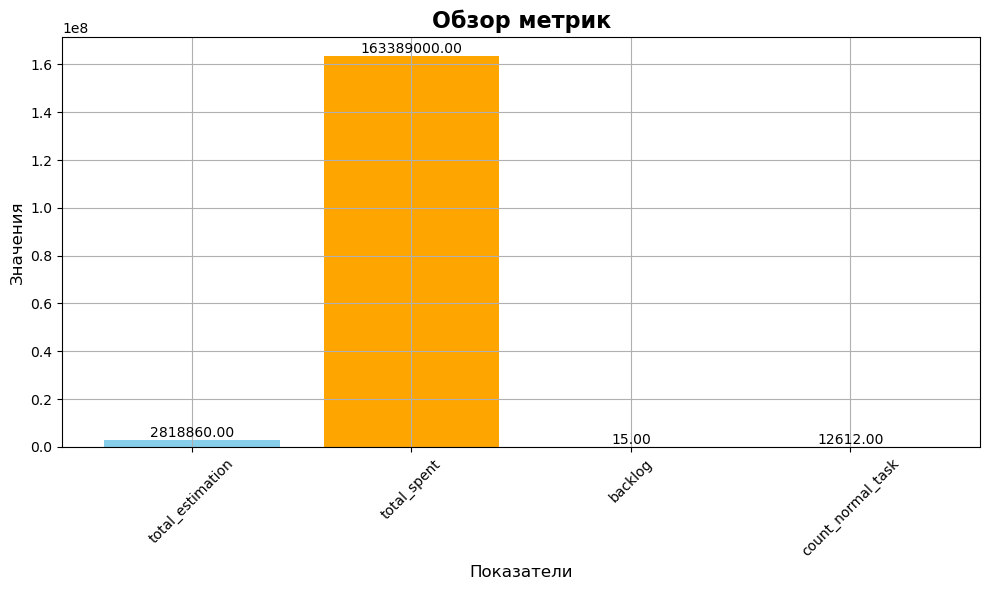

In [55]:
plt.figure(figsize=(10, 6))
bars = plt.bar(data.keys(), data.values(), color=['skyblue', 'orange', 'green', 'purple'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', 
             ha='center', va='bottom', fontsize=10, color='black')

plt.title('Обзор метрик', fontsize=16, fontweight='bold')
plt.ylabel('Значения', fontsize=12)
plt.xlabel('Показатели', fontsize=12)


plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.grid()

plt.show()